In [1]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

import re
import string

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn import metrics

import qgrid
# can't work
from jupyter_datatables import init_datatables_mode
import pandas_profiling


<JupyterRequire.display.SafeScript object>

In [2]:
%matplotlib inline
# init_datatables_mode()

In [3]:
import os, platform, subprocess, re
command = "cat /proc/cpuinfo"
all_info = subprocess.check_output(command, shell=True).strip()
for line in all_info.split(b"\n"):
    if b"model name" in line:
        print(re.sub( ".*model name.*:", "", line.decode(),1))

 Intel(R) Core(TM) i5-6400 CPU @ 2.70GHz
 Intel(R) Core(TM) i5-6400 CPU @ 2.70GHz
 Intel(R) Core(TM) i5-6400 CPU @ 2.70GHz
 Intel(R) Core(TM) i5-6400 CPU @ 2.70GHz


# Explore data

In [4]:
data = pd.read_csv('data/reddit.csv')

In [ ]:
qgrid.show_grid(data[['title', 'cat', 'url']])


In [ ]:
data.profile_report(style={'full_width':True})

In [ ]:
cat ~/miniconda2/envs/fastai-cpu/lib/python3.6/site-packages/jupyter_datatables/__init__.py

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
data.cat.value_counts().plot(kind='barh', figsize=(13, 30))

In [ ]:
data.groupby('cat').count()['url'].plot(kind='barh', figsize=(13, 30))

In [ ]:
cats_ordered = sorted(data.groupby('cat')['url'].count().items(), key=lambda x: x[1])
cats_ordered

# Clean data

In [ ]:
import spacy
from spacy.lang.en import English
from collections import Counter

In [ ]:
data['lens'] = data.title.map(lambda x: len(x))

In [ ]:
data.lens.describe()

In [ ]:
vocabs = data.title.to_string()

In [ ]:
nlp = English()
nlp.max_length = len(vocabs) + 1
vocabs_spacy = nlp(vocabs)

In [ ]:
words = [token.lemma_.lower() for token in vocabs_spacy if not token.is_stop and not token.is_punct and token.lemma_.strip() and not (47 < ord(token.text[0][0]) < 58)]

In [ ]:
word_freq = Counter(words)
print(word_freq.most_common(5))

In [ ]:
vocabs_dict = {}
vocabs_list = sorted(word_freq.items(), key=lambda x: x[1])
vocabs_list = [v for v in vocabs_list if not (47 < ord(v[0][0]) < 58)]

In [ ]:
ord('0'), ord('9'), chr(57)

In [ ]:
tmp = pd.DataFrame(vocabs_list)

In [ ]:
a = tmp[tmp[1] > 3][tmp[1] < 50]
print(a[1].describe())

s = [s for c, s in a[0].items()]
ss = {v: 1 for v in s}
print(len(s), s[:30], s[-30:])

In [ ]:
len(vocabs_list), vocabs_list[:30], vocabs_list[-500:-470], vocabs_list[-30:]

In [ ]:
def clean_sent(xs):
    return ' '.join([token.lemma_.strip().lower() 
                     for token in nlp(xs) 
                     if not token.is_stop 
                     and not token.is_punct 
                     and token.lemma_.strip() 
                     and token.lemma_.strip().lower() in ss
                     # and not (47 < ord(token.text[0][0]) < 58)
                    ])

data_cleaned = data.title.map(clean_sent)

In [ ]:
data_cleaned2 = data.copy()
data_cleaned2['title'] = data_cleaned

In [ ]:
data_cleaned2['lens'] = data_cleaned2.title.map(lambda x: len(x))

In [ ]:
data_cleaned3 = data_cleaned2[data_cleaned2.lens > 0]

In [ ]:
data_cleaned3.tail(n=10)

In [ ]:
data_cleaned3.lens.describe()

In [ ]:
len(data_cleaned3), len(data)

# Select feature 

In [ ]:
data_train, data_test, data_y_train, data_y_test = \
    train_test_split(data_cleaned3.title, data_cleaned3.cat, 
#                     train_size=0.3, 
                    test_size=0.2, 
                    random_state=42)

In [ ]:
data_train.shape, data_test.shape, data_y_train.shape

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english').fit(data_cleaned3.title)
X_vec_train = vectorizer.transform(data_train)
X_vec_test = vectorizer.transform(data_test)

In [ ]:
X_vec_train.shape

In [ ]:
le = LabelEncoder()
le.fit(data.cat)
y_train = le.transform(data_y_train)
y_test = le.transform(data_y_test)

In [ ]:
y_train.shape

In [ ]:
# select_chi2 = 5000
# ch2 = SelectKBest(chi2, k=select_chi2)
# X_train = ch2.fit_transform(X_vec_train, y_train)
# X_test = ch2.transform(X_vec_test)
# print(select_chi2)
X_train = X_vec_train
X_test = X_vec_test

In [ ]:
# le = LabelEncoder()
# le.fit(data_train)
# X_le_train = le.transform(data_train)
# X_le_test = le.transform(data_test)

In [ ]:
# pca = PCA(n_components=10).fit(X_le_train)
# X_train = pca.transform(X_le_train)
# X_test = pca.transform(X_le_test)

In [ ]:
print(y_train[:2], le.inverse_transform(y_train[:2]))
X_train.shape, X_test.shape

In [ ]:
data_train.head()

In [ ]:
feature_names = vectorizer.get_feature_names()
# feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

# Train

In [ ]:
# clf = BernoulliNB(alpha=.01)
# clf = RandomForestClassifier(n_estimators=3)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
pred = clf.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

# Pipline

In [77]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
# or use word2vec in spacy
import gensim
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163897 entries, 0 to 163896
Data columns (total 3 columns):
title    163897 non-null object
url      163897 non-null object
cat      163897 non-null object
dtypes: object(3)
memory usage: 3.8+ MB


In [79]:
data.cat.value_counts()

computer_sound           2890
raspberry_pi             2083
politics                 2061
gamedev                  1938
scifi                    1937
sysadmin                 1935
ios                      1933
painting                 1932
arduino                  1931
android                  1922
eos                      1919
devops                   1886
haskell                  1881
environment              1876
perl                     1872
go                       1866
emacs                    1860
crypto                   1852
docker                   1852
vim                      1845
ruby                     1836
rust                     1834
programming              1832
tor                      1831
windows                  1822
bitcoin                  1809
ai                       1808
c                        1807
git                      1803
science                  1799
                         ... 
data_science             1406
unix                     1359
julia     

In [80]:
data.cat.values

array(['life', 'life', 'life', ..., 'programming_tools',
       'programming_tools', 'programming_tools'], dtype=object)

In [81]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [82]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [83]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
feat_select = SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))

In [84]:
from sklearn.model_selection import train_test_split

cnts = data.cat.value_counts()
# acc: 0.62
data_selecteds = data[~data.cat.isin(cnts[(cnts < 1200) | (cnts > 1800)].index)].reset_index(drop=True)
# acc: 0.59
# data_selecteds = data[~data.cat.isin(cnts[(cnts < 500) | (cnts > 2000)].index)].reset_index(drop=True)

In [85]:
data_selecteds.cat.value_counts()

science             1799
computer_science    1785
hardware            1779
swift               1776
macos               1773
hacker_news         1772
php                 1753
big_data            1751
linux               1750
statistics          1748
cyberpunk           1743
datasets            1739
scala               1732
security            1716
space               1715
python              1714
html                1707
cpp                 1700
vscode              1690
decentralization    1688
life                1682
lisp                1677
computer_vision     1665
worldnews           1657
bash                1654
futurology          1651
clojure             1643
r                   1624
cyber_security      1607
visualization       1604
computing           1600
coding              1600
css                 1588
lua                 1586
kotlin              1581
movie               1568
deep_learning       1556
nlp                 1555
ocaml               1529
logic               1516


In [86]:
def merge_cats(cat):
    cat_map = dict(
        worldnews=['politics', 'environment'],
        science=['space', 'physics', 'philosophy', 'scientific_research', 'futurology'],
        computer_science=['computing', 'math', 'algorithm', 'logic', 'tiny_code', 
                          'software_architecture', 'decentralization', 'csbook'],
        machine_learning=['causality', 'data_science', 'statistics', 'big_data', 
                          'deep_learning', 'computer_sound', 'nlp', 'computer_vision', 
                          'datasets', 'ai', 'agi', 'robotics'],
        programming=['gamedev', 'coding'],
        programming_tools=['vim', 'emacs', 'vscode', 'intellij_idea', 'git'],
        programming_language=['forth', 'sml', 'tcl', 'objective_c', 'apl', 'prolog', 'smalltalk'],
        art=['literature', 'scifi', 'music', 'painting', 'dream', 'movie'],
        hardware=['raspberry_pi', 'arduino', ],
        devops=['sysadmin', 'docker', 'cloud_computing'],
        mobile=['ios', 'android'],
        os=['linux', 'unix', 'macos', 'windows', 'osdev', 'unikernel'],
        lisp=['scheme', 'clojure', 'common_lisp'],
        crypto=['eos', 'tor', 'i2p', 'bitcoin', 'crypto_currency', 'ethereum'],
        security=['cyberpunk', 'cyber_security', 'hacking'],
        database=['nosql'],
        other=['life'],
    )
    # see in confusion matrix for above cats predicts, add below:
    cat_map['devops'].extend(['go'])
    cat_map['machine_learning'].extend(['visualization'])
    cat_map['html'] = ['css']
    cat_map['mobile'].extend(['swift'])
    del cat_map['programming']
    del cat_map['computer_science']
    cat_map['algorithm'] = ['math', 'logic']
    cat_map['cpp'] = ['c']
    cat_map['os'].extend(['bash'])
    cat_map['art'].extend(['life'])
    del cat_map['other']
    cat_map['database'].extend(['decentralization'])
    
    for k, v in cat_map.items():
        if cat in v:
            return k
    return cat

# acc: 0.65
data_selecteds = data[data.cat != 'hacker_news'].reset_index(drop=True)
# see in confusion matrix for above cats predicts, add below:
data_selecteds = data_selecteds[~data_selecteds.cat.isin(
    ['computing', 'tiny_code', 'csbook', 'coding', 'programming', 'computer_science', 'software_architecture'])].reset_index(drop=True)

data_selecteds.cat = data_selecteds.cat.map(merge_cats)

# undersample reduced acc
# idxs = []
# for cat, cnt in data_selecteds.cat.value_counts().items():
#     idxs.extend(np.random.permutation(np.squeeze(np.argwhere(data_selecteds.cat == cat)))[:1250])
# data_selecteds = data_selecteds.loc[idxs].reset_index(drop=True)

data_selecteds.cat.value_counts()

machine_learning        21385
crypto                  11442
os                       9550
art                      9540
science                  8624
programming_tools        8430
devops                   8331
security                 6539
hardware                 5793
mobile                   5631
worldnews                5594
lisp                     5394
algorithm                4434
programming_language     4228
database                 3671
cpp                      3507
html                     3295
gamedev                  1938
haskell                  1881
perl                     1872
ruby                     1836
rust                     1834
php                      1753
scala                    1732
python                   1714
r                        1624
lua                      1586
kotlin                   1581
ocaml                    1529
erlang                   1515
javascript               1477
julia                    1275
java                     1263
asm       

In [87]:
_X_train, _X_test, _y_train, _y_test = train_test_split(data_selecteds.title, data_selecteds.cat, test_size=0.1)

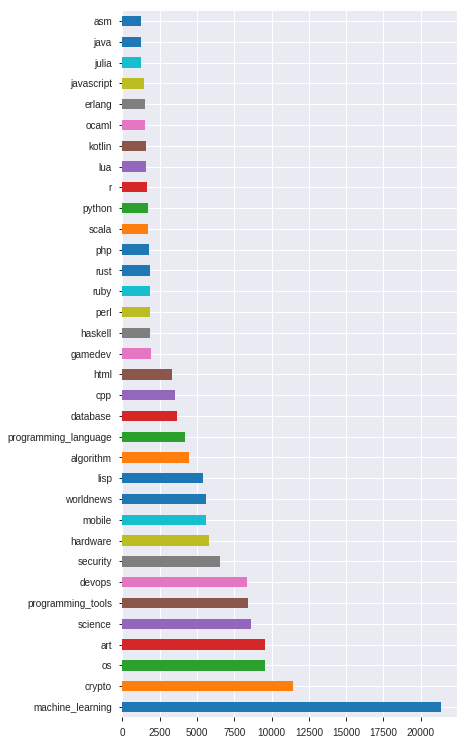

In [88]:
data_selecteds.cat.value_counts().plot(kind='barh', figsize=(6, 13))

In [89]:
len(data_selecteds.cat.unique())

34

In [90]:
data_selecteds.profile_report(style={'full_width':True})

In [91]:
resample = False
# resample pipline droped acc?
resample_pipline = False
# acc: 0.66
# ros = RandomOverSampler(random_state=0)
# acc: 0.73
# ros = ADASYN()
# acc: 0.76
ros = SMOTE()
# acc: 0.65
# ros = RandomUnderSampler()

In [92]:
if resample and not resample_pipline:
    preds = predictors().fit(_X_train)
    tmp = preds.transform(_X_train)
    tv = tfidf_vector.fit(tmp)
    tmp = tv.transform(tmp)

In [93]:
if resample and not resample_pipline:
    X_train, y_train = ros.fit_resample(tmp, _y_train)
else:
    X_train, y_train = _X_train, _y_train

In [94]:
if resample and not resample_pipline:
    tmp = preds.transform(_X_test)
    tmp = tv.transform(tmp)

In [95]:
if resample and not resample_pipline:
    X_test, y_test = ros.fit_resample(tmp, _y_test)
else:
    X_test, y_test = _X_test, _y_test

In [96]:
X_train.shape

(137746,)

In [97]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
# classifier = BernoulliNB(alpha=.01)
# classifier = ComplementNB(alpha=1)
# classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# classifier = SGDClassifier(n_jobs=-1, max_iter=10)
# acc: 0.71, high recall: 0.72
classifier = LinearSVC(class_weight='balanced', max_iter=1000)
# acc: 0.686, low recall: 0.65
# with SMOTE resample: acc: 0.73, recall: 0.73, but val/test(without resample) acc is low: 0.63
# classifier = LinearSVC(max_iter=1000)

if resample:
    if not resample_pipline:
        classifier.fit(X_train, y_train)
    else:
        pipe = make_pipeline_imb(predictors(),
                                 tfidf_vector,
                                 ros,
                                 classifier)
        pipe.fit(X_train,y_train)
else:
    # Create pipeline using Bag of Words
    pipe = Pipeline([("cleaner", predictors()),
                     ('vectorizer', tfidf_vector),
#                      ('feat_select', model_vector),
                     ('classifier', classifier)])

    # model generation
    pipe.fit(X_train,y_train)

In [98]:
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    target_names = labels
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    labels = data_selecteds.cat.unique()
    print('accuracy %s' % metrics.accuracy_score(target, predictions))
    cm = metrics.confusion_matrix(target, predictions, labels=labels)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, labels, title + ' Normalized')
    
def predict(X, y, classifier):
    predictions = classifier.predict(X)
    evaluate_prediction(predictions, y)
    return predictions

accuracy 0.7009669410688619
confusion matrix
 [[761  19  35 ...   6  10   5]
 [ 11 469  45 ...   2   1   0]
 [ 34  67 599 ...   2   2   1]
 ...
 [  2   0   1 ...  83   7   3]
 [ 11   0   1 ...   6 254   8]
 [  5   2   2 ...   8   7 583]]
(row=expected, col=predicted)
Accuracy: 0.7009669410688619
Precision: 0.6546180716403744
Recall: 0.7050693257860924


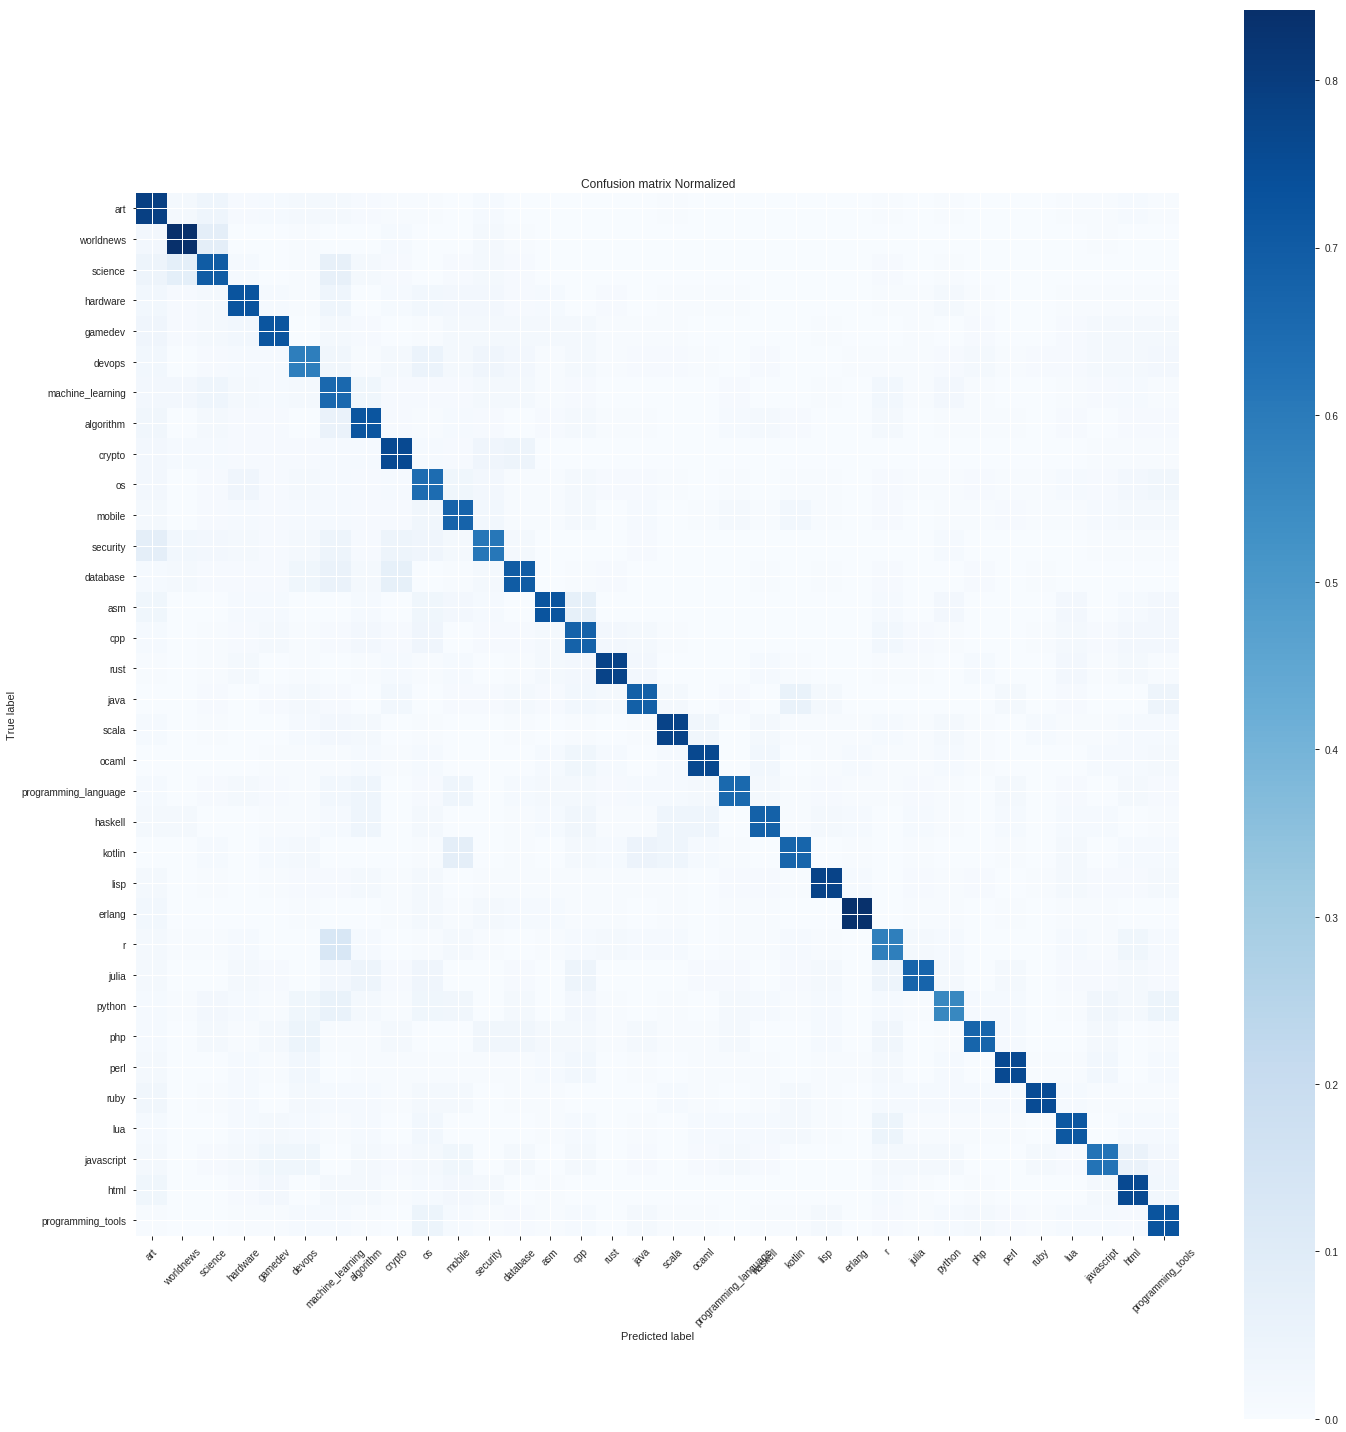

In [99]:
from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced
# Predicting with a test dataset
if resample:
    if not resample_pipline:
        predicted = classifier.predict(X_test)
    else:
        predicted = pipe.predict(X_test)
#     print(classification_report_imbalanced(y_test, y_pred))
else:
#     predicted = pipe.predict(X_test)
    predicted = predict(X_test, y_test, pipe)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted, average='macro'))
print("Recall:",metrics.recall_score(y_test, predicted, average='macro'))

In [100]:
X_pred = ['dfs: depth first search',
              'How SAML 2.0 Authentication Works',
              'What are the “best” codebases that you\'ve encountered?',
              'Book Review: Designing Data-Intensive Applications',
              'Some things that might help you make better software',
              'B-threads: programming in a way that allows for easier changes',
              'Browser extensions are underrated: the promise of hackable software',
              'Levels of code in Forth programming (2002)',
              'encode/decode gpt network',
             'it is not safe for software deploy',
              'learning web coding in scheme',
             'web code in nodejs',
             'luajit embed in c',
         'Dwindling CPAN Releases',
         'LightSail 2 Spacecraft Successfully Demonstrates Flight by Light',
          'Tokyo\'s audiophile venues ',
          'Composing better emails',
          'Alarming surge in drug-resistant HIV uncovered ',
          'LF: Fully Decentralized Fully Replicated Key/Value Store',
          'Hawaii Extends Thirty Meter Telescope Permit Amid Protests',
          'Show HN: Generate a fake app to replace any addictive app',
          'Most internet service providers are gone – Sonic has survived and thrived',
          'A Brief Guide to a Few Algebraic Structures ',
          'Implementing Poincaré Embeddings (2017)',
          'Launch HN: Hatchways (YC S19) – Internships Instead of Interviews',
          'The Enduring Mystery of ‘Jawn,’ Philadelphia’s All-Purpose Noun (2016) ',
          'Programming Algorithms: A Crash Course in Lisp',
          'A New York Farm Stand’s Success: An Eye for the Next Big Thing',
          'Music Recommendations in Hyperbolic Space',
          'The Ethics of Web Performance',
          'ThorShield Energy Weapon Protection Fabric',
          'ZRNA – Software-defined analog circuits',
          'Equifax removed the $125 claim payout option after millions submitted claims ',
          'Marvin Minsky and the Ultimate Tinker Toy ',
          'Filling hospitals with art reduces patient stress, anxiety and pain',
          'Actalis: Insufficient Serial Number Entropy ',
          'The Paradox of Toil (2010) ',
          'A Raspberry Pi-powered live train station sign ',
          'The Law Isn\'t Ready for Psychedelic Medicine',
          'A Transparent Display with Per-Pixel Color and Opacity Control',
          'Cortex – An ML model deployment platform that runs in your AWS account',
          'Plastic bag sales in England halved in past year',
          'A Look at Overnight Stays at US National Parks',
          'John Carmack on Parallel Implementations',
          'Knuth on Huang\'s Sensitivity Proof: “I\'ve got the proof down to one page” [pdf]',
          'A Readable Specification of TLS 1.3',
          'Ray tracing with uLisp',
          'Big O Notation – Using not-boring math to measure code’s efficiency ',
          'Solving differential equations on a 6502 with Woz\'s floating point code',
          'Machine Learning That’s Light Enough for an Arduino',
          'Detailed 3D map of Milky Way shows \'warped\' shape ',
          'GNU C Library 2.30',
          'A holographic view of a vertical plane, equally familiar and fulfilling in the first and final destination was the image of Jeremy and the countdown clock that had appeared in the hologram of the first moon orbiting above New Earth. “',
          'Contributing to the Mozilla code base',
          'A recurrent neural network for generating little stories about images',
          'Building a Programming Language Pt. 3 – Interpreting',
          'The Real Dark Web',
          'Things Reacters do that Re-framers avoid',
          'Low-level is easy (2008) ',
          'Standard Ebooks: Free public-domain ebooks, carefully produced ',
          'Living Near Trees, Not Just Green Space, Improves Wellbeing',
         ]
if resample:
    tmp = preds.transform(X_pred)
    tmp = tv.transform(tmp)
    for i, v in enumerate(classifier.predict(tmp)):
        print('(%s)' % v, X_pred[i])
else:
    for i, v in enumerate(pipe.predict(X_pred)):
        print('(%s)' % v, X_pred[i])


(algorithm) dfs: depth first search
(devops) How SAML 2.0 Authentication Works
(cpp) What are the “best” codebases that you've encountered?
(machine_learning) Book Review: Designing Data-Intensive Applications
(os) Some things that might help you make better software
(mobile) B-threads: programming in a way that allows for easier changes
(programming_tools) Browser extensions are underrated: the promise of hackable software
(programming_language) Levels of code in Forth programming (2002)
(os) encode/decode gpt network
(security) it is not safe for software deploy
(lisp) learning web coding in scheme
(javascript) web code in nodejs
(lua) luajit embed in c
(perl) Dwindling CPAN Releases
(science) LightSail 2 Spacecraft Successfully Demonstrates Flight by Light
(security) Tokyo's audiophile venues 
(ocaml) Composing better emails
(worldnews) Alarming surge in drug-resistant HIV uncovered 
(database) LF: Fully Decentralized Fully Replicated Key/Value Store
(worldnews) Hawaii Extends Thirt

In [112]:
import pickle

# https://cmry.github.io/notes/serialize
# https://cmry.github.io/notes/serialize-sk

pkl_filename = "data/%s_model.pkl" % classifier.__class__.__name__
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)
    
with open(pkl_filename, 'rb') as file:
    pipe = pickle.load(file)
    
pipe.predict(['dfs: depth first search'])

array(['algorithm'], dtype=object)